In [50]:
import os
import json


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

import keras
import tensorflow as tf


Populating the interactive namespace from numpy and matplotlib


In [22]:
from keras import Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, Sequence
from keras.applications import InceptionV3,inception_v3
from sklearn.metrics import f1_score

In [23]:
labels = json.load(open('data/reformatted_train.json'))


In [26]:
y = [labels[str(x)]['labelId'] for x in range(1,10000)]
y = [[int(x) for x in a] for a in y]
largest = 0
for l in y:
    for num in l:
        if num > largest:
            largest = num
NUM_CLASSES = largest
print(largest)

228


In [33]:
# "first stupid model" this is basically just the pretrained InceptionV3 convolutional layers with a 1000 unit 
# fully connected layer before the dense output layer. The output layer is a sigmoid rather than a softmax as the 
# problem is a multi-label multi-class problem

def create_model(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dense(1000, activation = 'relu', name = 'dense1')(X)
    X = Dense(1000, activation = 'relu', name = 'dense2')(X)
    predictions = Dense(NUM_CLASSES, activation = 'sigmoid', name = 'outlayer')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

In [45]:
#training_gen = data_gen.flow(X_train,y_train,seed = 42)
training_gen,Xval,yval = create_sequence_and_val(labels,1000,50,inception_v3.preprocess_input)

In [18]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [28]:
model1 = create_model(inception_base)

In [29]:
sgd = keras.optimizers.SGD(lr = .01, decay = .00001)
rmsprop = keras.optimizers.RMSprop(lr = .01, decay = .00001)
adam = keras.optimizers.Adam(lr = .001, decay = .00001)

In [30]:
model1.compile(optimizer = sgd, loss =  keras.losses.binary_crossentropy , metrics = ['accuracy'])

In [46]:
model1.fit_generator(training_gen,
                     epochs = 7,
                     steps_per_epoch= 20, 
                     validation_data = (Xval,yval),
                     workers = 6,
                     use_multiprocessing = True,
                     verbose = 1)

Epoch 1/7
20/20 [==============================] - 119s 6s/step - loss: 0.1066 - acc: 0.9762 - val_loss: 0.1046 - val_acc: 0.9769
Epoch 2/7
 1/20 [>.............................] - ETA: 2:45 - loss: 0.1025 - acc: 0.9767

Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Process ForkPoolWorker-30:
Process ForkPoolWorker-27:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/connor/anaconda3/lib/python3.6/multipr

KeyboardInterrupt: 

In [40]:
preds = model1.predict(Xval)

In [49]:
thresholds = np.linspace(0,1,100,endpoint=False)
f1s = []
for t in thresholds:
    y_hat = preds > t
    f1 = f1_score(yval,y_hat,average = 'micro')
    f1s.append(f1)

/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


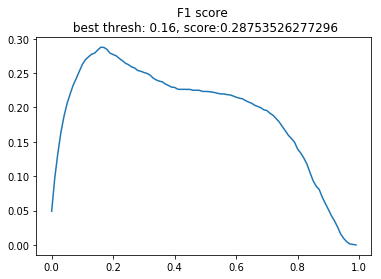

In [56]:
fig, ax = plt.subplots()
ax.plot(thresholds,f1s)
best = np.argmax(f1s)
ax.set_title("F1 score \n best thresh: {}, score:{}".format(thresholds[best],f1s[best]))
plt.show()